### BUILDING BINARY CLASSIFIERS

The training data observations are record pairs made up of infant death records registered in Washington state in 2016 and 2017 with birth records that were registered in the same year. The birth data used to create these candidate record pairs consists of the true birth records of the infants who died (i.e. true matches with the death records) as well as a random sample of an equal number of non-matching birth records. For each candidate birth-death record pair similarity scores were computed for variables the records have in common including the names of the infants, mothers, and fathers, dates of birth, sex, and county of residence.  The record pairs were also labeled with a variable called 'match' indicating whether they were matches (value = 1) or non-matches (value = 0).

Using these features and labels the two binary classifiers below were created using logistic regression and random forest methods.  A comparison of the results from each classifier will provide guidance on which method to use for future linkage projects.

In [1]:
import pandas as pd
import numpy as np
import recordlinkage as rl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

####  1. LOGISTIC REGRESSION CLASSIFIER

In [3]:
comp_scores_m = pd.read_csv(r'Y:\DQSS\Death\MBG\Py\data\clean\infdth_comparison_1617_labelled.csv',
                           index_col=[0,1])

df = comp_scores_m

In [5]:
# split data to separate features (X) and labels (y)

X = df[['cmp_inf_lname', 'cmp_inf_phonetic', 'cmp_dad_lname', 'cmp_mom_lname', 'cmp_rescounty', 'cmp_sex', 'cmp_mom_phonetic',
        'cmp_dad_phonetic', 'cmp_dobm', 'cmp_doby', 'cmp_dobd']]

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454323 entries, (12016000010, 52016000522) to (12017087228, 52017091113)
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   cmp_inf_lname     454323 non-null  int64
 1   cmp_inf_phonetic  454323 non-null  int64
 2   cmp_dad_lname     454323 non-null  int64
 3   cmp_mom_lname     454323 non-null  int64
 4   cmp_rescounty     454323 non-null  int64
 5   cmp_sex           454323 non-null  int64
 6   cmp_mom_phonetic  454323 non-null  int64
 7   cmp_dad_phonetic  454323 non-null  int64
 8   cmp_dobm          454323 non-null  int64
 9   cmp_doby          454323 non-null  int64
 10  cmp_dobd          454323 non-null  int64
dtypes: int64(11)
memory usage: 39.9 MB


In [7]:
# data split to separate features (X) and labels (y)
y = df[['match']]
y.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454323 entries, (12016000010, 52016000522) to (12017087228, 52017091113)
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   match   454323 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB


In [8]:
# split data into training and testing sets - 35% reserved for testing

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.35, 
                                                random_state=7)

In [9]:
testy.match.value_counts(dropna=False)

0    158801
1       213
Name: match, dtype: int64

In [10]:
# create logistic regression model

lrmodel = LogisticRegression(solver='lbfgs')

In [11]:
#fit model to training data.  Need to specify .values.ravel() to convert the 
# labels data (y) into a 1D array.

lrmodel_fitted = lrmodel.fit(trainX, trainy.values.ravel())
lrmodel_fitted 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
import joblib

joblib.dump(lrmodel_fitted, r'Y:\DQSS\Death\MBG\Py\infdth_logreg.sav' )

['Y:\\DQSS\\Death\\MBG\\Py\\infdth_logreg.sav']

In [13]:
# predict probabilites of records being in a given class for testing feature 
# data and the actual classes

lrmodel_probs = lrmodel.predict_proba(testX)
lrmodel_pred = lrmodel.predict(testX)

In [14]:
# separate out probabilities for the positive class only (matches)

lrmodel_probs = lrmodel_probs[:, 1]

In [15]:
# confusion matrix

lr_cr = classification_report(testy, lrmodel_pred, 
                              target_names = ['No Match', 'Match'],
                              output_dict=True)

pd.DataFrame.from_dict(lr_cr)

,No Match,Match,accuracy,macro avg,weighted avg
precision,0.999931,0.985366,0.999912,0.992648,0.999911
recall,0.999981,0.948357,0.999912,0.974169,0.999912
f1-score,0.999956,0.966507,0.999912,0.983232,0.999911
support,158801.000000,213.000000,0.999912,159014.000000,159014.000000


**Recall for 'No Match' = specificity; recall for 'Match' = sensitivity**

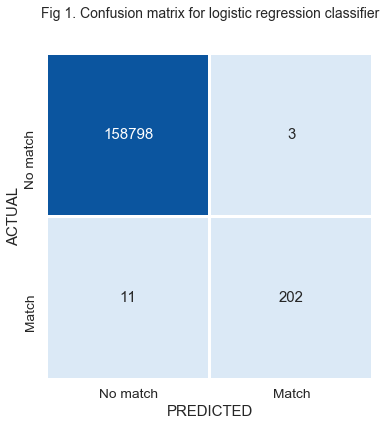

In [16]:
lr_cm = confusion_matrix(testy, lrmodel_pred)

plt.figure(figsize=(6, 6))
font = {'weight': 'normal',
        'size': 14} 

sns.set(font_scale=1.25)
sns.heatmap(lr_cm, 
            annot=True, fmt = 'g',
            square = True,
            cmap = sns.color_palette("Blues"),
            cbar = False,
            linewidths=2, linecolor='white',
            xticklabels = ['No match', 'Match'],
            yticklabels = ['No match', 'Match'])

plt.title('Fig 1. Confusion matrix for logistic regression classifier', 
          pad = 35, fontdict = font)
plt.xlabel('PREDICTED');plt.ylabel('ACTUAL');         
plt.show()        


The classification report and confusion matrix above indicates that the logistic regression model had a sensitivity of almost 95% and specificity of 99.9%. For record linkage projects relating to administrative health data, it is more important to have a high specificity meaning very few false positive cases. Having record pairs classified as matches when they are actually not matches would be of greater concern than missing a few true matches by classifying them as 'no match'.


In [16]:
lr_auc = roc_auc_score(testy, lrmodel_probs)

In [17]:

print('Logistic: ROC AUC=%.5f' % (lr_auc))

Logistic: ROC AUC=1.00000


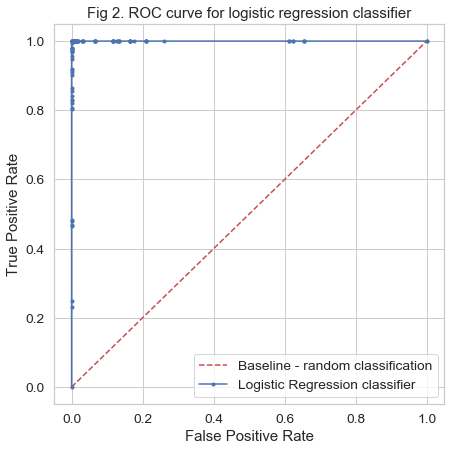

In [18]:
# calculate roc curve
lr_fpr, lr_tpr, _ = roc_curve(testy, lrmodel_probs)
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
plt.title('Fig 2. ROC curve for logistic regression classifier')
# plot roc curve for the model
plt.plot([0, 1], [0, 1],'r--', label='Baseline - random classification')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

The ROC curve for the logistic regression classifier is also an indicator of the accuracy of the logistic regression classifier. The plot of true positive and false positive rates for the classifier above maximizes the area under the curve.

###### EXAMINING RECORDS THAT WERE INCORRECTLY PREDICTED

To manually review record pairs that were incorrectly classified by the logistic regression model the predictions stored in the object created when the model was applied to the test data set can be joined with the test data containing the true labels and the record numbers (multi-index) for the birth and death records in the misclassified pairs. Examining the features of the record pairs may yield some insight into how the model might be improved and will also allow manually correcting the misclassification.

In [19]:
## to identify the records that the logistic regression model predicted were 
## matches:

predictions = lrmodel_pred
lr_testy = pd.DataFrame(testy).copy()
lr_testy['prediction'] = predictions
lr_testy[lr_testy['match'] != lr_testy['prediction']].head(25)

,,match,prediction
12017016969,52017013228,0,1
12017016351,52017009800,1,0
12017017473,52017015618,1,0
12016056506,52016044038,1,0
12017029348,52017022864,1,0
12017030502,52017022632,1,0
12017025353,52017020121,1,0
12016036019,52016022637,1,0
12016036210,52016014776,1,0
12016034539,52016024096,0,1


#### 2. RANDOM FOREST CLASSIFIER

Random forest is a probabilistic classifier and is not as affected by data issues such as imbalanced classes and multicollinearity. For this reason, random forest may be a more convenient classfier to apply. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# create random forest model with 100 trees

rfmodel = RandomForestClassifier(n_estimators=100,
                                bootstrap = True,
                                max_features = 'sqrt')


In [22]:
# fit on training data

rfmodel_fitted = rfmodel.fit(trainX, trainy.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
import joblib

joblib.dump(rfmodel_fitted, r'Y:\DQSS\Death\MBG\Py\infdth_randfor.sav' )

In [23]:
#predict classes on test data
rfmodel_pred = rfmodel.predict(testX)

#probabilities for each class
rfmodel_probs = rfmodel.predict_proba(testX)[:,1]

In [24]:
type(rfmodel_probs)

numpy.ndarray

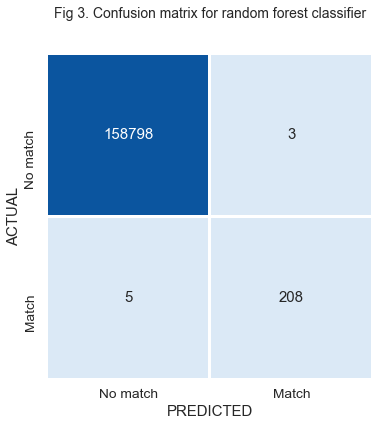

In [25]:
rf_cm = confusion_matrix(testy, rfmodel_pred)

plt.figure(figsize=(6, 6))
font = {'weight': 'normal',
        'size': 14} 

sns.set(font_scale=1.25)
sns.heatmap(rf_cm, 
            annot=True, fmt = 'g',
            square = True,
            cmap = sns.color_palette("Blues"),
            cbar = False,
            linewidths=2, linecolor='white',
            xticklabels = ['No match', 'Match'],
            yticklabels = ['No match', 'Match'])

plt.title('Fig 3. Confusion matrix for random forest classifier', 
          pad = 35, fontdict = font)
plt.xlabel('PREDICTED');plt.ylabel('ACTUAL');         
plt.show()        

In [26]:
rf_cr = classification_report(testy, rfmodel_pred, output_dict=True,
                                   target_names = ['No Match', 'Match'])

pd.DataFrame.from_dict(rf_cr)

,No Match,Match,accuracy,macro avg,weighted avg
precision,0.999969,0.985782,0.99995,0.992875,0.99995
recall,0.999981,0.976526,0.99995,0.988253,0.99995
f1-score,0.999975,0.981132,0.99995,0.990553,0.99995
support,158801.000000,213.000000,0.99995,159014.000000,159014.00000


**Recall for 'No Match' = specificity; recall for 'Match' = sensitivity**

The random forest classfier achieved sensitivity of 97.7% and specificity of 99.9%.

In [27]:
rf_auc = roc_auc_score(testy, rfmodel_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rfmodel_probs)

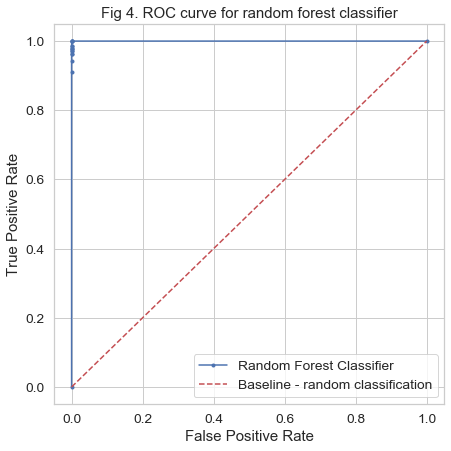

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
plt.plot(rf_fpr, rf_tpr, marker='.', label="Random Forest Classifier")
plt.plot([0, 1], [0, 1],'r--', label='Baseline - random classification')
plt.title('Fig 4. ROC curve for random forest classifier')
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### COMPARING CLASSIFIERS

In terms of performance as well as the effort required to prepare the training data set random forest method is a better choice for this record linkage project.  As a next step, I will apply both classifiers to a validation data set (which is also labeled) to see how their accuracy levels compare.

###### Feature importance ranking for random forest classifier

The computational load involved with creating a random forest classifier may be lessened by exploring the relative importance of the features used in the classification.  The table below shows the importance of each feature in rank order.  Based on this information, I will recreate the random forest classifier excluding date of birth year and possibly also sex as features in the model.

In [29]:
# feature importance

imp = np.ndarray.round(rfmodel.feature_importances_, 6)

feature_importance = pd.DataFrame({'feature': list(trainX.columns),
                        'importance': imp}).\
                       sort_values('importance', ascending = False)
feature_importance         

,feature,importance
1,cmp_inf_phonetic,0.292779
0,cmp_inf_lname,0.231775
5,cmp_dad_phonetic,0.171723
3,cmp_mom_phonetic,0.128178
4,cmp_dad_lname,0.055030
2,cmp_mom_lname,0.037880
8,cmp_dobd,0.034054
6,cmp_dobm,0.024792
10,cmp_rescounty,0.012580
9,cmp_sex,0.009648


#### NEXT STEPS

The purpose of this project was to find ways to implement record linkage of large administrative datasets without the need for manual review.

The two classifiers above show promise in linking infant death records with their corresponding birth records.  Both methods were supervised learning methods requiring labeled training data. It may not be feasible to use these methods to link other health data sets.

I plan to apply these methods to 2018 and 2019 infant death data to validate the classification accuracy of bothe methods. However, for other data sets that don't have labeled data I will also explore unsupervised learning classifiers.